Notebook for generating Grad-CAM, filters and feature maps visualization

In [1]:
# import libraries
%matplotlib inline
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torchcam.methods import LayerCAM
from PIL.Image import Resampling
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import glob
import cv2
import os

In [2]:
# folder used for inspection (should have Train & Test folder inside)
datafolder = "../VGG16/VGG1692800438.442319" # <== add the folder path

NBR_CLASSES = 2
transform =   transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
    ])
model = torch.load(datafolder+"/model",map_location=torch.device('cpu'))
model.eval()
model.cpu()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Freeze the network parameters

In [3]:
for layer in model.classifier.parameters():
    layer.requires_grad = True
for layer in model.features.parameters():
    layer.requires_grad = True 

In [4]:
# Get the Conv layers in the model
i = 0
Conv_layers_indexes = []
model_conv_layers =[]

for layer in model.features:
    if 'Conv' in str(layer):
        # Keep the indexe
        Conv_layers_indexes.append(i)
        # Keep the layer
        model_conv_layers.append(layer)
    i += 1

print("Indexs of Conv layers: ",Conv_layers_indexes)

Indexs of Conv layers:  [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]


- We add some functions for each on of the three techniques:

1. Filter visualization functions:
   
   By getting the weights from Conv layers

In [5]:
def filters_visualization(layer_index):
    """Filter visualization

    Args:
        layer_index (int): Layer to visualize
    """
    #Get the layer and check if it's a Conv layer
    layer = model.features[layer_index]
    if 'Conv' in str(type(layer)):
        weights = layer.weight.detach()
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape)
        filter_cnt=1
        
        #plotting all the filters
        #to reduce computation we limit the filters to only first 10
        plt.figure()
        for i in range(10 if filters.shape[0] > 10 else filters.shape[0]):
            #get the filters
            filt=filters[i,:,:,:]
            #plotting each of the channel, color image RGB channels
            for j in range(10 if filters.shape[1] > 10 else filters.shape[1]):
                ax= plt.subplot(10 if filters.shape[1] > 10 else filters.shape[1], 10 if filters.shape[0] > 10 else filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[j,:,:])
                filter_cnt+=1
        plt.show()

2 Class Activation Map:

By using `pytorch_grad_cam` library to generate the Maps

In [6]:
def CAM_generation(model, image, Class, onlyLastLayer):  
    # Preprocess your data and feed it to the model
    size = 224
    cam_extractor = LayerCAM(model, target_layer=["features."+str(i) for i in Conv_layers_indexes] if onlyLastLayer else "features."+str(Conv_layers_indexes[-2]))
    img = np.array(Image.open(image))
    img = cv2.resize(img, (size, size))
    tensorImg = transform(np.float32(img) / 255)
    if tensorImg.shape[0] == 3:
        tensor = tensorImg.reshape(1,3,size,size)
    else:
        tensor = tensorImg.unsqueeze(0).repeat(1,3,1,1)
    
    out = model(tensor)
    # Retrieve the CAM by passing the class index and the model output
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    # Overlayed on the image and the raw CAM
    fused_cam = cam_extractor.fuse_cams(cams)
    plt.figure(figsize=(40, 10))
    plt.subplot(2, 8, 1)
    plt.imshow(fused_cam.squeeze(0).numpy())
    plt.axis('off')
    plt.title("Fused GradCAM" if onlyLastLayer else "One layer GradCAM")
    plt.subplot(2, 8, 2)
    overlay = to_pil_image(fused_cam.squeeze(0), mode='F').resize(to_pil_image(img).size, resample=Resampling.BICUBIC)
    overlay = (255 * (np.asarray(overlay) ** 2)).astype(np.uint8)
    plt.imshow(tensorImg[0], cmap="gray")
    plt.imshow(overlay, cmap="jet", alpha=0.5*(np.asarray(overlay)>0))
    plt.axis('off')
    plt.title("Class: "+Class)
    plt.subplot(2, 8, 3)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.title("Image")
    plt.show()    

    # Once you're finished, clear the hooks on your model
    cam_extractor.remove_hooks()

In [7]:
# Load images from the folder (we use 30 images per class)
NBR_CLASSES = len(os.listdir(datafolder+"/Test/"))
classes = {c:[] for c in range(NBR_CLASSES)}
classesNames = {c:"" for c in range(NBR_CLASSES)}
i = 0
for dir in os.listdir(datafolder+"/Test/"):
    classesNames[i] = dir
    for image in glob.glob(datafolder+"/Test/"+dir+"/*"):
        classes[i].append(image)
    i += 1
dataSize = len(classes.items())

Using the next function we can :
- Pick an image from one of the classes and perform object detection first, then apply the following:
  
  - Filter visualization of one of the Conv layers
  - Class Activation Map

Image selection is done randomly once the class is selected

In [8]:
def inspector():
    input_value = -1
    input_class = ""
    print("Select one of the classes ",classesNames)
    input_class = int(input())
    if input_class in classes:
        selected_image = classes[input_class][np.random.randint(0,len(classes[input_class]))]
    else:
        selected_image = classes[0][np.random.randint(0,len(classes[0]))]
    while input_value != 0:
        while input_value != 5:
            print("=================")
            print("Inspection Menu")
            print("=================")
            print("Select action:")
            print("1- Filter visualization")
            print("2- Class Acitvation Map (One layer GradCAM)")
            print("3- Class Acitvation Map (Fused GradCAM)")
            print("4- Change the picture")
            print("5- Exit")

            input_value = int(input())
            if input_value in [1,2,3,4]:
                if input_value == 1:
                    #Filter visualization
                    print("Select Conv layer",Conv_layers_indexes)
                    conv_index = int(input())
                    filters_visualization(conv_index)

                if input_value == 2:
                    #Class Acitvation Map (Last layer GradCAM)
                    CAM_generation(model, selected_image,classesNames[input_class],False)
                if input_value == 3:
                    #Class Acitvation Map (Fused GradCAM)
                    CAM_generation(model, selected_image,classesNames[input_class],True)
                if input_value == 4:
                    #Select another image
                    print("Select one of the classes ",classesNames)
                    input_class = int(input())
                    if input_class in classes:
                        selected_image = classes[input_class][np.random.randint(0,len(classes[input_class]))]
            else:
                break
        else:
            break


Select one of the classes  {0: 'cf. chalara', 1: 'chalara'}
Inspection Menu
Select action:
1- Filter visualization
2- Class Acitvation Map (One layer GradCAM)
3- Class Acitvation Map (Fused GradCAM)
4- Change the picture
5- Exit


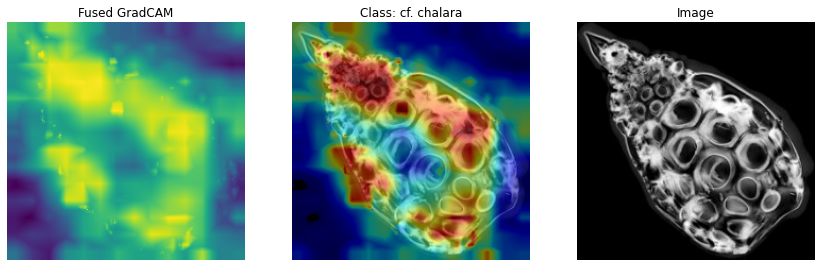

Inspection Menu
Select action:
1- Filter visualization
2- Class Acitvation Map (One layer GradCAM)
3- Class Acitvation Map (Fused GradCAM)
4- Change the picture
5- Exit
Select one of the classes  {0: 'cf. chalara', 1: 'chalara'}
Inspection Menu
Select action:
1- Filter visualization
2- Class Acitvation Map (One layer GradCAM)
3- Class Acitvation Map (Fused GradCAM)
4- Change the picture
5- Exit


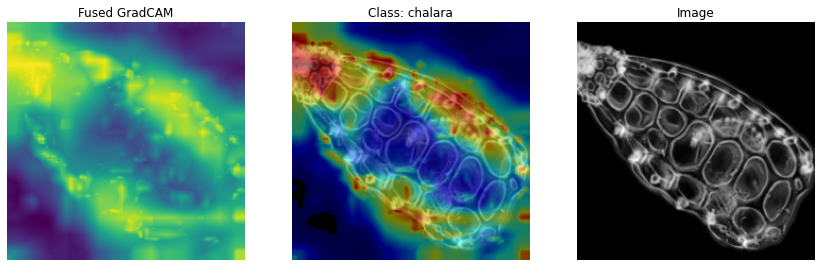

Inspection Menu
Select action:
1- Filter visualization
2- Class Acitvation Map (One layer GradCAM)
3- Class Acitvation Map (Fused GradCAM)
4- Change the picture
5- Exit


In [9]:
%matplotlib inline
inspector()